<img src="https://miro.medium.com/max/2652/1*eTkBMyqdg9JodNcG_O4-Kw.jpeg" width="100%">

[Image Source](https://medium.com/stanford-ai-for-healthcare/its-a-no-brainer-deep-learning-for-brain-mr-images-f60116397472)

# Brain Tumor Auto-Segmentation for Magnetic Resonance Imaging (MRI)
Welcome to the final part of the "Artificial Intelligence for Medicine" course 1!

You will learn how to build a neural network to automatically segment tumor regions in brain, using [MRI (Magnetic Resonance Imaging](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging)) scans.

The MRI scan is one of the most common image modalities that we encounter in the radiology field.  
Other data modalities include: 
- [Computer Tomography (CT)](https://en.wikipedia.org/wiki/CT_scan), 
- [Ultrasound](https://en.wikipedia.org/wiki/Ultrasound)
- [X-Rays](https://en.wikipedia.org/wiki/X-ray). 

In this assignment we will be focusing on MRIs but many of our learnings applies to other mentioned modalities as well.  We'll walk you through some of the steps of training a deep learning model for segmentation.

**You will learn:**

-   What is in an MR image
-   Standard data preparation techniques for MRI datasets
-   Metrics and loss functions for segmentation
-   Visualizing and evaluating segmentation models

## Outline
Use these links to jump to particular sections of this assignment!

- [1. Dataset](#1)
  - [1.1 What is an MRI?](#1-1)
  - [1.2 MRI Data Processing](#1-2)
  - [1.3 Exploring the Dataset](#1-3)
  - [1.4 Data Preprocessing](#1-4)
    - [1.4.1 Sub-volume Sampling](#1-4-1)
    - [1.4.2 Standardization](#1-4-2)
- [2. Model: 3D U-Net](#2)
- [3. Metrics](#3)
  - [3.1 Dice Coefficient](#3-1)
  - [3.2 Soft Dice Loss](#3-2)
- [4. Training](#4)
- [5. Evaluation](#5)
  - [5.1 Overall Performance](#5-1)
  - [5.2 Patch-level Predictions](#5-2)
  - [5.3 Running on Entire Scans](#5-3)

## Packages

In this assignment, we'll make use of the following packages:

- `keras` is a framework for building deep learning models.
- `keras.backend` allows us to perform math operations on tensors.
- `nibabel` will let us extract the images and labels from the files in our dataset.
- `numpy` is a library for mathematical and scientific operations.
-  `pandas` is what we'll use to manipulate our data.

## Import Packages

Run the next cell to import all the necessary packages, dependencies and custom util functions.

In [1]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K 

import util

Using TensorFlow backend.


<a name="1"></a>
# 1 Dataset
<a name="1-1"></a>
## 1.1 What is an MRI?

Magnetic resonance imaging (MRI) is an advanced imaging technique that is used to observe a variety of diseases and parts of the body. 

As we will see later, neural networks can analyze these images individually (as a radiologist would) or combine them into a single 3D volume to make predictions.

At a high level, MRI works by measuring the radio waves emitting by atoms subjected to a magnetic field. 

<img src="https://miro.medium.com/max/1740/1*yC1Bt3IOzNv8Pp7t1v7F1Q.png">

In this assignment, we'll build a multi-class segmentation model. We'll  identify 3 different abnormalities in each image: edemas, non-enhancing tumors, and enhancing tumors.

<a name="1-2"></a>

## 1.2 MRI Data Processing

We often encounter MR images in the [DICOM format](https://en.wikipedia.org/wiki/DICOM). 
- The DICOM format is the output format for most commercial MRI scanners. This type of data can be processed using the [pydicom](https://pydicom.github.io/pydicom/stable/getting_started.html) Python library. 

In this assignment, we will be using the data from the [Decathlon 10 Challenge](https://decathlon-10.grand-challenge.org). This data has been mostly pre-processed for the competition participants, however in real practice, MRI data needs to be significantly pre-preprocessed before we can use it to train our models.

<a name="1-3"></a>
## 1.3 Exploring the Dataset

Our dataset is stored in the [NifTI-1 format](https://nifti.nimh.nih.gov/nifti-1/) and we will be using the [NiBabel library](https://github.com/nipy/nibabel) to interact with the files. Each training sample is composed of two separate files:

The first file is an image file containing a 4D array of MR image in the shape of (240, 240, 155, 4). 
-  The first 3 dimensions are the X, Y, and Z values for each point in the 3D volume, which is commonly called a voxel. 
- The 4th dimension is the values for 4 different sequences
    - 0: FLAIR: "Fluid Attenuated Inversion Recovery" (FLAIR)
    - 1: T1w: "T1-weighted"
    - 2: t1gd: "T1-weighted with gadolinium contrast enhancement" (T1-Gd)
    - 3: T2w: "T2-weighted"

The second file in each training example is a label file containing a 3D array with the shape of (240, 240, 155).  
- The integer values in this array indicate the "label" for each voxel in the corresponding image files:
    - 0: background
    - 1: edema
    - 2: non-enhancing tumor
    - 3: enhancing tumor

We have access to a total of 484 training images which we will be splitting into a training (80%) and validation (20%) dataset.

Let's begin by looking at one single case and visualizing the data! You have access to 10 different cases via this notebook and we strongly encourage you to explore the data further on your own.

We'll use the [NiBabel library](https://nipy.org/nibabel/nibabel_images.html) to load the image and label for a case. The function is shown below to give you a sense of how it works. 

In [2]:
# set home directory and data directory
HOME_DIR = "./BraTS-Data/"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

We'll now visualize an example.  For this, we use a pre-defined function we have written in the `util.py` file that uses `matplotlib` to generate a summary of the image. 

The colors correspond to each class.
- Red is edema
- Green is a non-enhancing tumor
- Blue is an enhancing tumor. 

Do feel free to look at this function at your own time to understand how this is achieved.

In [ ]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
image = util.get_labeled_image(image, label)

util.plot_image_grid(image)

We've also written a utility function which generates a GIF that shows what it looks like to iterate over each axis.

In [4]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
util.visualize_data_gif(util.get_labeled_image(image, label))

**Reminder:** You can explore more images in the `imagesTr` directory by changing the image name file.

<a name="1-4"></a>
## 1.4 Data Preprocessing using patches

While our dataset is provided to us post-registration and in the NIfTI format, we still have to do some minor pre-processing before feeding the data to our model. 

##### Generate sub-volumes

We are going to first generate "patches" of our data which you can think of as sub-volumes of the whole MR images. 
- The reason that we are generating patches is because a network that can process the entire volume at once will simply not fit inside our current environment's memory/GPU.
- Therefore we will be using this common technique to generate spatially consistent sub-volumes of our data, which can be fed into our network.
- Specifically, we will be generating randomly sampled sub-volumes of shape \[160, 160, 16\] from our images. 
- Furthermore, given that a large portion of the MRI volumes are just brain tissue or black background without any tumors, we want to make sure that we pick patches that at least include some amount of tumor data. 
- Therefore, we are only going to pick patches that have at most 95% non-tumor regions (so at least 5% tumor). 
- We do this by filtering the volumes based on the values present in the background labels.

##### Standardization (mean 0, stdev 1)

Lastly, given that the values in MR images cover a very wide range, we will standardize the values to have a mean of zero and standard deviation of 1. 
- This is a common technique in deep image processing since standardization makes it much easier for the network to learn.

Let's walk through these steps in the following exercises.

<a name="1-4-1"></a>
### 1.4.1 Sub-volume Sampling
Fill in the function below takes in:
- a 4D image (shape: \[240, 240, 155, 4\])
- its 3D label (shape: \[240, 240, 155\]) arrays, 

The function returns:
 - A randomly generated sub-volume of size \[160, 160, 16\]
 - Its corresponding label in a 1-hot format which has the shape \[3, 160, 160, 160\]

Additionally: 
1. Make sure that at most 95% of the returned patch is non-tumor regions. 
2. Given that our network expects the channels for our images to appear as the first dimension (instead of the last one in our current setting) reorder the dimensions of the image to have the channels appear as the first dimension.
3. Reorder the dimensions of the label array to have the first dimension as the classes (instead of the last one in our current setting)
4. Reduce the labels array dimension to only include the non-background classes (total of 3 instead of 4)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Check the lecture notebook for a similar example in 1 dimension</li>
    <li>To check the ratio of background to the whole sub-volume, the numerator is the number of background labels in the sub-volume.  The last dimension of the label array at index 0 contains the labels to identify whether the voxel is a background (value of 1) or not a a background (value of 0).
        </li>
    <li>For the denominator of the background ratio, this is the volume of the output (see <code>output_x</code>, <code>output_y</code>, <code>output_z</code> in the function parameters).</li>
    <li><a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical">keras.utils.to_categorical(y, num_classes=)</a></li>
    <li><a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.moveaxis.html" > np.moveaxis </a> can help you re-arrange the dimensions of the arrays </li>
    <li> <a href="https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randint.html">np.random.randint</a> for random sampling</li>
    <li> When taking a subset of the label <code>'y'</code> that excludes the background class, remember which dimension contains the <code>'num_classes'</code> channel after re-ordering the axes. </li>
</ul>
</p>

In [4]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image, 
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label. 
            labels coded using discrete values rather than
            a separate dimension, 
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction 
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension 
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension 
            (num_classes, output_x, output_y, output_z)
    """
    # Initialize features and labels with `None`
    X = None
    y = None

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(orig_x - output_x + 1)
        start_y = np.random.randint(orig_y - output_y + 1)
        start_z = np.random.randint(orig_z - output_z + 1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]

        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes=num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:, :, :, 0])/(output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X, -1, 0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, -1, 0)

            ### END CODE HERE ###
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

### Test Case:

In [5]:
np.random.seed(3)

image = np.zeros((4, 4, 3, 1))
label = np.zeros((4, 4, 3))
for i in range(4):
    for j in range(4):
        for k in range(3):
            image[i, j, k, 0] = i*j*k
            label[i, j, k] = k

print("image:")
for k in range(3):
    print(f"z = {k}")
    print(image[:, :, k, 0])
print("\n")
print("label:")
for k in range(3):
    print(f"z = {k}")
    print(label[:, :, k])

image:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[0. 0. 0. 0.]
 [0. 1. 2. 3.]
 [0. 2. 4. 6.]
 [0. 3. 6. 9.]]
z = 2
[[ 0.  0.  0.  0.]
 [ 0.  2.  4.  6.]
 [ 0.  4.  8. 12.]
 [ 0.  6. 12. 18.]]


label:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
z = 2
[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]]


#### Test: Extracting (2, 2, 2) sub-volume

In [6]:
sample_image, sample_label = get_sub_volume(image, 
                                            label,
                                            orig_x=4, 
                                            orig_y=4, 
                                            orig_z=3,
                                            output_x=2, 
                                            output_y=2, 
                                            output_z=2,
                                            num_classes = 3)

print("Sampled Image:")
for k in range(2):
    print("z = " + str(k))
    print(sample_image[0, :, :, k])

Sampled Image:
z = 0
[[0. 2.]
 [0. 3.]]
z = 1
[[0. 4.]
 [0. 6.]]


#### Expected output:

```Python
Sampled Image:
z = 0
[[0. 2.]
 [0. 3.]]
z = 1
[[0. 4.]
 [0. 6.]]
```

In [7]:
print("Sampled Label:")
for c in range(2):
    print("class = " + str(c))
    for k in range(2):
        print("z = " + str(k))
        print(sample_label[c, :, :, k])

Sampled Label:
class = 0
z = 0
[[1. 1.]
 [1. 1.]]
z = 1
[[0. 0.]
 [0. 0.]]
class = 1
z = 0
[[0. 0.]
 [0. 0.]]
z = 1
[[1. 1.]
 [1. 1.]]


#### Expected output:

```Python
Sampled Label:
class = 0
z = 0
[[1. 1.]
 [1. 1.]]
z = 1
[[0. 0.]
 [0. 0.]]
class = 1
z = 0
[[0. 0.]
 [0. 0.]]
z = 1
[[1. 1.]
 [1. 1.]]
```

You can run the following cell to look at a candidate patch and ensure that the function works correctly. We'll look at the enhancing tumor part of the label.

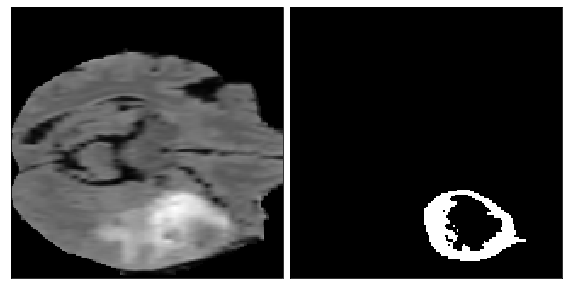

In [8]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_001.nii.gz", DATA_DIR + "labelsTr/BRATS_001.nii.gz")
X, y = get_sub_volume(image, label)
# enhancing tumor is channel 2 in the class label
# you can change indexer for y to look at different classes
util.visualize_patch(X[0, :, :, :], y[2])

<a name="1-4-2"></a>
### 1.4.2 Standardization

Next, fill in the following function that given a patch (sub-volume), standardizes the values across each channel and each Z plane to have a mean of zero and standard deviation of 1. 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Check that the standard deviation is not zero before dividing by it.
</ul>
</p>

In [9]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def standardize(image):
    """
    Standardize mean and standard deviation 
        of each channel and z_dimension.

    Args:
        image (np.array): input image, 
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros((image.shape[0],
                                   image.shape[1],
                                   image.shape[2],
                                   image.shape[3]))

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - np.mean(image_slice)

            centered_scaled = centered/np.std(centered)

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled

    ### END CODE HERE ###

    return standardized_image

And to sanity check, let's look at the output of our function:

In [10]:
X_norm = standardize(X)
print("standard deviation for a slice should be 1.0")
print(f"stddv for X_norm[0, :, :, 0]: {X_norm[0,:,:,0].std():.2f}")

standard deviation for a slice should be 1.0
stddv for X_norm[0, :, :, 0]: 1.00


Let's visualize our patch again just to make sure (it won't look different since the `imshow` function we use to visualize automatically normalizes the pixels when displaying in black and white).

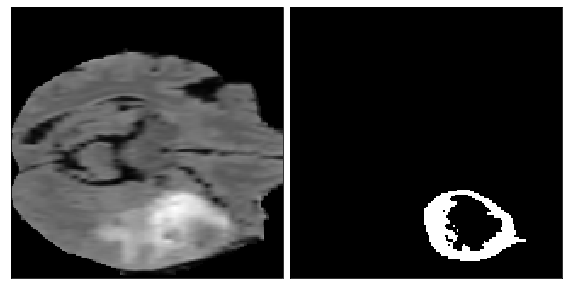

In [11]:
util.visualize_patch(X_norm[0, :, :, :], y[2])

<a name="2"></a>
# 2 Model: 3D U-Net
Now let's build our model. In this assignment we will be building a [3D U-net](https://arxiv.org/abs/1606.06650). 
- This architecture will take advantage of the volumetric shape of MR images and is one of the best performing models for this task. 
- Feel free to familiarize yourself with the architecture by reading [this paper](https://arxiv.org/abs/1606.06650).

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="50%">

<a name="3"></a>
# 3 Metrics

<a name="3-1"></a>
## 3.1 Dice Similarity Coefficient

Aside from the architecture, one of the most important elements of any deep learning method is the choice of our loss function. 

A natural choice that you may be familiar with is the cross-entropy loss function. 
- However, this loss function is not ideal for segmentation tasks due to heavy class imbalance (there are typically not many positive regions). 

A much more common loss for segmentation tasks is the Dice similarity coefficient, which is a measure of how well two contours overlap. 
- The Dice index ranges from 0 (complete mismatch) 
- To 1 (perfect match).

In general, for two sets $A$ and $B$, the Dice similarity coefficient is defined as: 
$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}.$$

Here we can interpret $A$ and $B$ as sets of voxels, $A$ being the predicted tumor region and $B$ being the ground truth. 

Our model will map each voxel to 0 or 1
- 0 means it is a background voxel
- 1 means it is part of the segmented region.

In the dice coefficient, the variables in the formula are:
- $x$ : the input image
- $f(x)$ : the model output (prediction)
- $y$ : the label (actual ground truth)

The dice coefficient "DSC" is:

$$\text{DSC}(f, x, y) = \frac{2 \times \sum_{i, j} f(x)_{ij} \times y_{ij} + \epsilon}{\sum_{i,j} f(x)_{ij} + \sum_{i, j} y_{ij} + \epsilon}$$

- $\epsilon$ is a small number that is added to avoid division by zero

<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="30%">

[Image Source](https://www.researchgate.net/figure/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from_fig4_328671987)

Implement the dice coefficient for a single output class below.

- Please use the [Keras.sum(x,axis=)](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sum) function to compute the numerator and denominator of the dice coefficient.

In [12]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def single_class_dice_coefficient(y_true, y_pred, axis=(0, 1, 2), 
                                  epsilon=0.00001):
    """
    Compute dice coefficient for single class.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for single class.
                                    shape: (x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for single class.
                                    shape: (x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    dice_numerator = 2*K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = dice_numerator / dice_denominator
    
    ### END CODE HERE ###

    return dice_coefficient

In [13]:
# TEST CASES
sess = K.get_session()
#sess = tf.compat.v1.Session()
with sess.as_default() as sess:
    pred = np.expand_dims(np.eye(2), -1)
    label = np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), -1)

    print("Test Case #1")
    print("pred:")
    print(pred[:, :, 0])
    print("label:")
    print(label[:, :, 0])

    # choosing a large epsilon to help check for implementation errors
    dc = single_class_dice_coefficient(pred, label,epsilon=1)
    print(f"dice coefficient: {dc.eval():.4f}")

    print("\n")

    print("Test Case #2")
    pred = np.expand_dims(np.eye(2), -1)
    label = np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), -1)

    print("pred:")
    print(pred[:, :, 0])
    print("label:")
    print(label[:, :, 0])

    # choosing a large epsilon to help check for implementation errors
    dc = single_class_dice_coefficient(pred, label,epsilon=1)
    print(f"dice_coefficient: {dc.eval():.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000


Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
dice_coefficient: 0.8333


##### Expected output

If you get a different result, please check that you implemented the equation completely.
```Python
Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000


Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
dice_coefficient: 0.8333
```

### Dice Coefficient for Multiple classes
Now that we have the single class case, we can think about how to approach the multi class context. 
- Remember that for this task, we want segmentations for each of the 3 classes of abnormality (edema, enhancing tumor, non-enhancing tumor). 
- This will give us 3 different dice coefficients (one for each abnormality class). 
- To combine these, we can just take the average. We can write that the overall dice coefficient is: 

$$DC(f, x, y) = \frac{1}{3} \left ( DC_{1}(f, x, y) + DC_{2}(f, x, y) + DC_{3}(f, x, y) \right )$$

- $DC_{1}$, $DC_{2}$ and $DC_{3}$ are edema, enhancing tumor, and non-enhancing tumor dice coefficients.

For any number of classes, the equation becomes:  
$$DC(f, x, y) = \frac{1}{N} \sum_{c=1}^{C} \left ( DC_{c}(f, x, y) \right )$$

In this case, with three categories, $C = 3$

Implement the mean dice coefficient below. This should not be very different from your singe-class implementation.


Please use the [K.mean](https://keras.io/backend/#mean) function to take the average of the three classes.  
- Apply the mean to the ratio that you calculate in the last line of code that you'll implement.

In [14]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    dice_numerator = 2*K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean(dice_numerator / dice_denominator)
    
    ### END CODE HERE ###

    return dice_coefficient

In [15]:
# TEST CASES
sess = K.get_session()
with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

    print("Test Case #1")
    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = dice_coefficient(pred, label,epsilon=1)
    print(f"dice coefficient: {dc.eval():.4f}")

    print("\n")

    print("Test Case #2")
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), 0), -1)


    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = dice_coefficient(pred, label,epsilon=1)
    print(f"dice coefficient: {dc.eval():.4f}")
    print("\n")


    print("Test Case #3")
    pred = np.zeros((2, 2, 2, 1))
    pred[0, :, :, :] = np.expand_dims(np.eye(2), -1)
    pred[1, :, :, :] = np.expand_dims(np.eye(2), -1)
    
    label = np.zeros((2, 2, 2, 1))
    label[0, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), -1)
    label[1, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), -1)

    print("pred:")
    print("class = 0")
    print(pred[0, :, :, 0])
    print("class = 1")
    print(pred[1, :, :, 0])
    print("label:")
    print("class = 0")
    print(label[0, :, :, 0])
    print("class = 1")
    print(label[1, :, :, 0])

    dc = dice_coefficient(pred, label,epsilon=1)
    print(f"dice coefficient: {dc.eval():.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000


Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.8333


Test Case #3
pred:
class = 0
[[1. 0.]
 [0. 1.]]
class = 1
[[1. 0.]
 [0. 1.]]
label:
class = 0
[[1. 1.]
 [0. 0.]]
class = 1
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.7167


#### Expected output:

```Python
Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000


Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.8333


Test Case #3
pred:
class = 0
[[1. 0.]
 [0. 1.]]
class = 1
[[1. 0.]
 [0. 1.]]
label:
class = 0
[[1. 1.]
 [0. 0.]]
class = 1
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.7167
```

<a name="3-2"></a>
## 3.2 Soft Dice Loss

While the Dice Coefficient makes intuitive sense, it is not the best for training. 
- This is because it takes in discrete values (zeros and ones). 
- The model outputs *probabilities* that each pixel is, say, a tumor or not, and we want to be able to backpropagate through those outputs. 

Therefore, we need an analogue of the Dice loss which takes real valued input. This is where the **Soft Dice loss** comes in. The formula is: 

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{2\times\sum_{i, j} p_{ij}q_{ij} + \epsilon}{\left(\sum_{i, j} p_{ij}^2 \right) + \left(\sum_{i, j} q_{ij}^2 \right) + \epsilon}$$

- $p$ is our predictions
- $q$ is the ground truth 
- In practice each $q_i$ will either be 0 or 1. 
- $\epsilon$ is a small number that is added to avoid division by zero

The soft Dice loss ranges between 
- 0: perfectly matching the ground truth distribution $q$
- 1: complete mismatch with the ground truth.

You can also check that if $p_i$ and $q_i$ are each 0 or 1, then the soft Dice loss is just one minus the dice coefficient.


### Multi-Class Soft Dice Loss

We've explained the single class case for simplicity, but the multi-class generalization is exactly the same as that of the dice coefficient. 
- Since you've already implemented the multi-class dice coefficient, we'll have you jump directly to the multi-class soft dice loss.

For any number of categories of diseases, the expression becomes:

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{1}{N} \sum_{c=1}^{C} \frac{2\times\sum_{i, j} p_{cij}q_{cij} + \epsilon}{\left(\sum_{i, j} p_{cij}^2 \right) + \left(\sum_{i, j} q_{cij}^2 \right) + \epsilon}$$

Please implement the soft dice loss below!

As before, you will use K.mean()
- Apply the average the mean to ratio that you'll calculate in the last line of code that you'll implement.

In [16]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    dice_numerator = 2*K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)

    ### END CODE HERE ###

    return dice_loss

#### Test Case 1

In [17]:
# TEST CASES
sess = K.get_session()
with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

    print("Test Case #1")
    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss:{dc.eval():.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
soft dice loss:0.4000


#### Expected output:

```Python
Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
soft dice loss:0.4000
```

#### Test Case 2

In [18]:
sess = K.get_session()
with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)
    
    print("Test Case #2")
    pred = np.expand_dims(np.expand_dims(0.5*np.eye(2), 0), -1)
    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])
    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss: {dc.eval():.4f}")

Test Case #2
pred:
[[0.5 0. ]
 [0.  0.5]]
label:
[[1. 1.]
 [0. 0.]]
soft dice loss: 0.4286


#### Expected output:

```Python
Test Case #2
pred:
[[0.5 0. ]
 [0.  0.5]]
label:
[[1. 1.]
 [0. 0.]]
soft dice loss: 0.4286
```

#### Test Case 3

In [19]:
sess = K.get_session()
with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)
    
    print("Test Case #3")
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), 0), -1)

    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss: {dc.eval():.4f}")

Test Case #3
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
soft dice loss: 0.1667


#### Expected output:

```Python
Test Case #3
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
soft dice loss: 0.1667
```

#### Test Case 4

In [20]:
sess = K.get_session()
with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

    print("Test Case #4")
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    pred[0, 0, 1, 0] = 0.8
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), 0), -1)

    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss: {dc.eval():.4f}")

Test Case #4
pred:
[[1.  0.8]
 [0.  1. ]]
label:
[[1. 1.]
 [0. 1.]]
soft dice loss: 0.0060


#### Expected output:

```Python
Test Case #4
pred:
[[1.  0.8]
 [0.  1. ]]
label:
[[1. 1.]
 [0. 1.]]
soft dice loss: 0.0060
```

#### Test Case 5

In [21]:
sess = K.get_session()
with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)
    
    print("Test Case #5")
    pred = np.zeros((2, 2, 2, 1))
    pred[0, :, :, :] = np.expand_dims(0.5*np.eye(2), -1)
    pred[1, :, :, :] = np.expand_dims(np.eye(2), -1)
    pred[1, 0, 1, 0] = 0.8

    label = np.zeros((2, 2, 2, 1))
    label[0, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), -1)
    label[1, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), -1)

    print("pred:")
    print("class = 0")
    print(pred[0, :, :, 0])
    print("class = 1")
    print(pred[1, :, :, 0])
    print("label:")
    print("class = 0")
    print(label[0, :, :, 0])
    print("class = 1")
    print(label[1, :, :, 0])

    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss: {dc.eval():.4f}")

Test Case #5
pred:
class = 0
[[0.5 0. ]
 [0.  0.5]]
class = 1
[[1.  0.8]
 [0.  1. ]]
label:
class = 0
[[1. 1.]
 [0. 0.]]
class = 1
[[1. 1.]
 [0. 1.]]
soft dice loss: 0.2173


#### Expected output:

```Python
Test Case #5
pred:
class = 0
[[0.5 0. ]
 [0.  0.5]]
class = 1
[[1.  0.8]
 [0.  1. ]]
label:
class = 0
[[1. 1.]
 [0. 0.]]
class = 1
[[1. 1.]
 [0. 1.]]
soft dice loss: 0.2173
```

#### Test Case 6

In [22]:
# Test case 6
pred = np.array([
                    [
                        [ 
                            [1.0, 1.0], [0.0, 0.0]
                        ],
                        [
                            [1.0, 0.0], [0.0, 1.0]
                        ]
                    ],
                    [
                        [ 
                            [1.0, 1.0], [0.0, 0.0]
                        ],
                        [
                            [1.0, 0.0], [0.0, 1.0]
                        ]
                    ],
                  ])
label = np.array([
                    [
                        [ 
                            [1.0, 0.0], [1.0, 0.0]
                        ],
                        [
                            [1.0, 0.0], [0.0, 0.0]
                        ]
                    ],
                    [
                        [ 
                            [0.0, 0.0], [0.0, 0.0]
                        ],
                        [
                            [1.0, 0.0], [0.0, 0.0]
                        ]
                    ]
                  ])

sess = K.get_session()
print("Test case #6")
with sess.as_default() as sess:
    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss",dc.eval())

Test case #6
soft dice loss 0.4375


#### Expected Output
```Python
Test case #6
soft dice loss: 0.4375
```

Note, if you don't have a scalar, and have an array with more than one value, please check your implementation!

<a name="4"></a>
# 4 Create and Train the model

Once you've finished implementing the soft dice loss, we can create the model! 

We'll use the `unet_model_3d` function in `utils` which we implemented for you.
- This creates the model architecture and compiles the model with the specified loss functions and metrics. 
- Check out function `util.unet_model_3d(loss_function)` in the `util.py` file.

In [23]:
model = util.unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


<a name="4-1"></a>
## 4.1 Training on a Large Dataset

In order to facilitate the training on the large dataset:
- We have pre-processed the entire dataset into patches and stored the patches in the [`h5py`](http://docs.h5py.org/en/stable/) format. 
- We also wrote a custom Keras [`Sequence`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) class which can be used as a `Generator` for the keras model to train on large datasets. 
- Feel free to look at the `VolumeDataGenerator` class in `util.py` to learn about how such a generator can be coded.

Note: [Here](https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/) you can check the difference between `fit` and `fit_generator` functions.

To get a flavor of the training on the larger dataset, you can run the following cell to train the model on a small subset of the dataset (85 patches). You should see the loss going down and the dice coefficient going up. 

Running `model.fit()` on the Coursera workspace may cause the kernel to die.
- Soon, we will load a pre-trained version of this model, so that you don't need to train the model on this workspace.

```Python
# Run this on your local machine only
# May cause the kernel to die if running in the Coursera platform

base_dir = HOME_DIR + "processed/"

with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)

# Get generators for training and validation sets
train_generator = util.VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=3, dim=(160, 160, 16), verbose=0)
valid_generator = util.VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=3, dim=(160, 160, 16), verbose=0)

steps_per_epoch = 20
n_epochs=10
validation_steps = 20

model.fit_generator(generator=train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        use_multiprocessing=True,
        validation_data=valid_generator,
        validation_steps=validation_steps)

# run this cell if you to save the weights of your trained model in cell section 4.1
#model.save_weights(base_dir + 'my_model_pretrained.hdf5')
```

<a name="4-2"></a>
## 4.2 Loading a Pre-Trained Model
As in assignment 1, instead of having the model train for longer, we'll give you access to a pretrained version. We'll use this to extract predictions and measure performance.

In [24]:
# run this cell if you didn't run the training cell in section 4.1
base_dir = HOME_DIR + "processed/"
with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)
# Get generators for training and validation sets
train_generator = util.VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=3, dim=(160, 160, 16), verbose=0)
valid_generator = util.VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=3, dim=(160, 160, 16), verbose=0)

In [25]:
model.load_weights(HOME_DIR + "model_pretrained.hdf5")

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 160, 160,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 160, 160, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 160, 160, 0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 64, 160, 160, 55360       activation_1[0][0]               
____________________________________________________________________________________________

<a name="5"></a>
# 5 Evaluation

Now that we have a trained model, we'll learn to extract its predictions and evaluate its performance on scans from our validation set.

<a name="5-1"></a>
## 5.1 Overall Performance

First let's measure the overall performance on the validation set. 
- We can do this by calling the keras [evaluate_generator](https://keras.io/models/model/#evaluate_generator) function and passing in the validation generator, created in section 4.1. 

#### Using the validation set for testing
- Note: since we didn't do cross validation tuning on the final model, it's okay to use the validation set.
- For real life implementations, however, you would want to do cross validation as usual to choose hyperparamters and then use a hold out test set to assess performance

Python Code for measuring the overall performance on the validation set:

```python
val_loss, val_dice = model.evaluate_generator(valid_generator)

print(f"validation soft dice loss: {val_loss:.4f}")
print(f"validation dice coefficient: {val_dice:.4f}")
```

#### Expected output:

```Python
validation soft dice loss: 0.4742
validation dice coefficient: 0.5152
```

**NOTE:** Do not run the code shown above on the Coursera platform as it will exceed the platform's memory limitations. However, you can run the code shown above locally on your machine or in Colab to practice measuring the overall performance on the validation set.


Like we mentioned above, due to memory limitiations on the Coursera platform we won't be runing the above code, however, you should take note of the **expected output** below it. We should note that due to the randomness in choosing sub-volumes, the values for soft dice loss and dice coefficient will be different each time that you run it.

<a name="5-2"></a>
## 5.2 Patch-level predictions

When applying the model, we'll want to look at segmentations for individual scans (entire scans, not just the sub-volumes)
- This will be a bit complicated because of our sub-volume approach. 
- First let's keep things simple and extract model predictions for sub-volumes.
- We can use the sub-volume which we extracted at the beginning of the assignment.

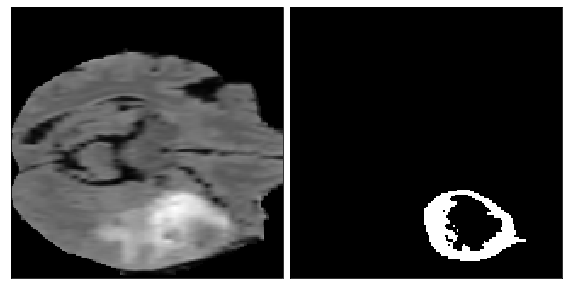

In [27]:
util.visualize_patch(X_norm[0, :, :, :], y[2])

#### Add a 'batch' dimension
We can extract predictions by calling `model.predict` on the patch. 
- We'll add an `images_per_batch` dimension, since the `predict` method is written to take in batches. 
- The dimensions of the input should be `(images_per_batch, num_channels, x_dim, y_dim, z_dim)`.
- Use [numpy.expand_dims](https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html) to add a new dimension as the zero-th dimension by setting axis=0

In [28]:
X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
patch_pred = model.predict(X_norm_with_batch_dimension)

#### Convert prediction from probability into a category
Currently, each element of `patch_pred` is a number between 0.0 and 1.0.
- Each number is the model's confidence that a voxel is part of a given class. 
- You will convert these to discrete 0 and 1 integers by using a threshold. 
- We'll use a threshold of 0.5. 
- In real applications, you would tune this to achieve your required level  of sensitivity or specificity.

In [29]:
# set threshold.
threshold = 0.5

# use threshold to get hard predictions
patch_pred[patch_pred > threshold] = 1.0
patch_pred[patch_pred <= threshold] = 0.0

Now let's visualize the original patch and ground truth alongside our thresholded predictions.

Patch and ground truth


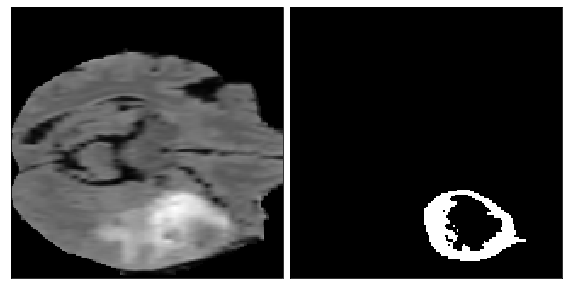

Patch and prediction


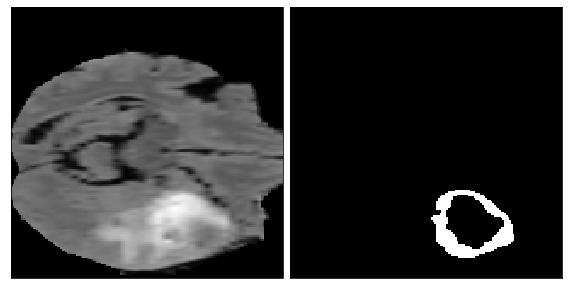

In [30]:
print("Patch and ground truth")
util.visualize_patch(X_norm[0, :, :, :], y[2])
plt.show()
print("Patch and prediction")
util.visualize_patch(X_norm[0, :, :, :], patch_pred[0, 2, :, :, :])
plt.show()

#### Sensitivity and Specificity

The model is covering some of the relevant areas, but it's definitely not perfect. 
- To quantify its performance, we can use per-pixel sensitivity and specificity. 

Recall that in terms of the true positives, true negatives, false positives, and false negatives, 

$$\text{sensitivity} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$\text{specificity} = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$

Below let's write a function to compute the sensitivity and specificity per output class.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Recall that a true positive occurs when the class prediction is equal to 1, and the class label is also equal to 1</li>
    <li>Use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html" > numpy.sum() </a> </li>

</ul>
</p>

In [31]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.

    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.

    Returns:
        sensitivity (float): precision for given class_num.
        specificity (float): recall for given class_num
    """

    # extract sub-array for specified class
    class_pred = pred[class_num]
    class_label = label[class_num]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute:
    
    # true positives
    tp = np.sum( (class_pred == 1) * (class_label == 1))

    # true negatives
    tn = np.sum( (class_pred == 0) * (class_label == 0))
    
    #false positives
    fp = np.sum( (class_pred == 1) * (class_label == 0))
    
    # false negatives
    fn =  np.sum( (class_pred == 0) * (class_label == 1))

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    ### END CODE HERE ###

    return sensitivity, specificity

In [32]:
# TEST CASES
pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

print("Test Case #1")
print("pred:")
print(pred[0, :, :, 0])
print("label:")
print(label[0, :, :, 0])

sensitivity, specificity = compute_class_sens_spec(pred, label, 0)
print(f"sensitivity: {sensitivity:.4f}")
print(f"specificity: {specificity:.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
sensitivity: 0.5000
specificity: 0.5000


#### Expected output:

```Python
Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
sensitivity: 0.5000
specificity: 0.5000
```

In [33]:
print("Test Case #2")

pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), 0), -1)

print("pred:")
print(pred[0, :, :, 0])
print("label:")
print(label[0, :, :, 0])

sensitivity, specificity = compute_class_sens_spec(pred, label, 0)
print(f"sensitivity: {sensitivity:.4f}")
print(f"specificity: {specificity:.4f}")

Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
sensitivity: 0.6667
specificity: 1.0000


#### Expected output:

```Python
Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
sensitivity: 0.6667
specificity: 1.0000
```

In [34]:
# Note: we must explicity import 'display' in order for the autograder to compile the submitted code
# Even though we could use this function without importing it, keep this import in order to allow the grader to work
from IPython.display import display
print("Test Case #3")

df = pd.DataFrame({'y_test': [1,1,0,0,0,0,0,0,0,1,1,1,1,1],
                   'preds_test': [1,1,0,0,0,1,1,1,1,0,0,0,0,0],
                   'category': ['TP','TP','TN','TN','TN','FP','FP','FP','FP','FN','FN','FN','FN','FN']
                  })

display(df)
pred = np.array( [df['preds_test']])
label = np.array( [df['y_test']])

sensitivity, specificity = compute_class_sens_spec(pred, label, 0)
print(f"sensitivity: {sensitivity:.4f}")
print(f"specificity: {specificity:.4f}")

Test Case #3


,y_test,preds_test,category
0,1,1,TP
1,1,1,TP
2,0,0,TN
3,0,0,TN
4,0,0,TN
5,0,1,FP
6,0,1,FP
7,0,1,FP
8,0,1,FP
9,1,0,FN


sensitivity: 0.2857
specificity: 0.4286


#### Expected Output

```Python
Test case #3
...
sensitivity: 0.2857
specificity: 0.4286
```

#### Sensitivity and Specificity for the patch prediction

Next let's compute the sensitivity and specificity on that patch for expanding tumors. 

In [35]:
sensitivity, specificity = compute_class_sens_spec(patch_pred[0], y, 2)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.7891
Specificity: 0.9960


#### Expected output:

```Python
Sensitivity: 0.7891
Specificity: 0.9960
```

We can also display the sensitivity and specificity for each class.

In [36]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [37]:
df = get_sens_spec_df(patch_pred[0], y)

print(df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.9085              0.9505          0.7891
Specificity  0.9848              0.9961           0.996


#### Expected output
```Python
              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.9085              0.9505          0.7891
Specificity  0.9848              0.9961           0.996
```

<a name="5-3"></a>
## 5.3 Running on entire scans
As of now, our model just runs on patches, but what we really want to see is our model's result on a whole MRI scan. 

- To do this, generate patches for the scan.
- Then we run the model on the patches. 
- Then combine the results together to get a fully labeled MR image.

The output of our model will be a 4D array with 3 probability values for each voxel in our data. 
- We then can use a threshold (which you can find by a calibration process) to decide whether or not to report a label for each voxel. 

We have written a function that stitches the patches together:  `predict_and_viz(image, label, model, threshold)` 
- Inputs: an image, label and model.
- Ouputs: the model prediction over the whole image, and a visual of the ground truth and prediction. 

Run the following cell to see this function in action!

#### Note: the prediction takes some time!
- The first prediction will take about 7 to 8 minutes to run.
- You can skip running this first prediction to save time.

In [38]:
# uncomment this code to run it
# image, label = load_case(DATA_DIR + "imagesTr/BRATS_001.nii.gz", DATA_DIR + "labelsTr/BRATS_001.nii.gz")
# pred = util.predict_and_viz(image, label, model, .5, loc=(130, 130, 77))                

Here's a second prediction.
- Takes about 7 to 8 minutes to run

Please run this second prediction so that we can check the predictions.

In [39]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
pred = util.predict_and_viz(image, label, model, .5, loc=(130, 130, 77))                

KeyboardInterrupt: 

#### Check how well the predictions do

We can see some of the discrepancies between the model and the ground truth visually. 
- We can also use the functions we wrote previously to compute sensitivity and specificity for each class over the whole scan.
- First we need to format the label and prediction to match our functions expect.

In [ ]:
whole_scan_label = keras.utils.to_categorical(label, num_classes = 4)
whole_scan_pred = pred

# move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]

Now we can compute sensitivity and specificity for each class just like before.

In [ ]:
whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)

# That's all for now!
Congratulations on finishing this challenging assignment! You now know all the basics for building a neural auto-segmentation model for MRI images. We hope that you end up using these skills on interesting and challenging problems that you face in the real world.



